## Importing Libraries and Datasets

In [30]:
import pandas as pd
import numpy as np
import json
import ast
import re
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression

In [31]:
df = pd.read_csv('rr_train_calculated.csv')

In [32]:
df.drop(columns=['MEETING_VOC', 'MAIL_VOC'], axis=1, inplace=True)
df.head(1)

,Unnamed: 0,POTENTIALID,ACTIVITY_TIMESTAMP,ACTIVITY,CONTACTID,ACCOUNTID,INVOICEGRANDTOTAL,DEALSTAGE,CALL_VOC,EVENT_VOC,QUOTE_VOC,SALESORDER_VOC,INVOICE_VOC,CLASS_TAG,MAILSUBJECT,MAILBODY,MAILTYPE,EMAIL_VOC
0,0,4064020918195738439,2025-07-13 11:34:32,email,2484255440287370664,1606923137163711337,NaN,Prospecting,NaN,NaN,NaN,NaN,NaN,closed won,Your Interest in the Hearth Kitchen Remodel - ...,"Dear Melody Harrison,\n\nThank you for your in...",outgoing,"{""sentiment"": ""Positive"", ""intent"": ""Purchase""..."


In [33]:
df.rename(columns={
    "POTENTIALID": "deal_id",
    "ACTIVITY_TIMESTAMP": "timestamp",
    "ACTIVITY": "activity_type",
    "CONTACTID": "contact_id",
    "ACCOUNTID": "account_id",
    "CALL_VOC": "call_voc",
    "EMAIL_VOC": "email_voc",
    "EVENT_VOC": "event_voc",
    "INVOICE_VOC": "invoice_voc",
    "QUOTE_VOC": "quote_voc",
    "SALESORDER_VOC": "salesorder_voc",
    "DEALSTAGE": "deal_stage",
    "CLASS_TAG": "class_tag",
    "INVOICEGRANDTOTAL": "deal_amount",
}, inplace=True)

df["timestamp"] = pd.to_datetime(df["timestamp"])

## Extracting values of VOC columns

In [34]:
# Mapping activity_type to corresponding voc column
voc_mapping = {
    'email': 'email_voc',
    'call': 'call_voc',
    'meeting': 'event_voc',
    'quote': 'quote_voc',
    'salesorder': 'salesorder_voc',
    'invoice': 'invoice_voc'
}

# Function to get voc dict based on activity_type
def extract_voc(row):
    voc_col = voc_mapping.get(row.get('activity_type'))
    if voc_col is None or voc_col not in row:
        return None

    voc_data = row[voc_col]
    if pd.isna(voc_data):   # handles NaN / None
        return None

    if isinstance(voc_data, str):
        try:
            voc_data = ast.literal_eval(voc_data)  # safely parse string dict
        except Exception:
            return None

    return voc_data if isinstance(voc_data, dict) else None

# Extract into separate columns safely
df['voc_dict'] = df.apply(extract_voc, axis=1)

df['sentiment'] = df['voc_dict'].apply(lambda x: x.get('sentiment') if isinstance(x, dict) else None)
df['intent']    = df['voc_dict'].apply(lambda x: x.get('intent') if isinstance(x, dict) else None)
df['emotion']   = df['voc_dict'].apply(lambda x: x.get('emotion') if isinstance(x, dict) else None)

# Drop temp column if not needed
df.drop(columns=['voc_dict'], inplace=True)


## Mapping VOC columns as numerics

In [35]:
sentiment_map = {"Positive": 1, "Neutral": 0.5, "Negative": 0.2}
intent_map = {
    "Purchase": 1.0, "Gratitude": 0.9, "Request": 0.8, "Query": 0.6,
    "Complaint": 0.2, "Others": 0.3
}
emotion_map = {
    "Happy": 1.0, "Gratitude": 0.9, "Trust": 0.9,
    "Neutral": 0.5, "Confusion": 0.3, "Frustration": 0.2, "Discontentment": 0.2
}

df["sentiment_score"] = df["sentiment"].map(sentiment_map)
df["intent_score"] = df["intent"].map(intent_map)
df["emotion_score"] = df["emotion"].map(emotion_map)

## Plot contact behaviour trends

In [63]:
closed_won = [2715541719177611254, 2484255440287370664, 2671509371774747715]
closed_lost = [2834433405134195310, 2519706180276546680, 2246628913815662506]


------Contacts with winning deals------



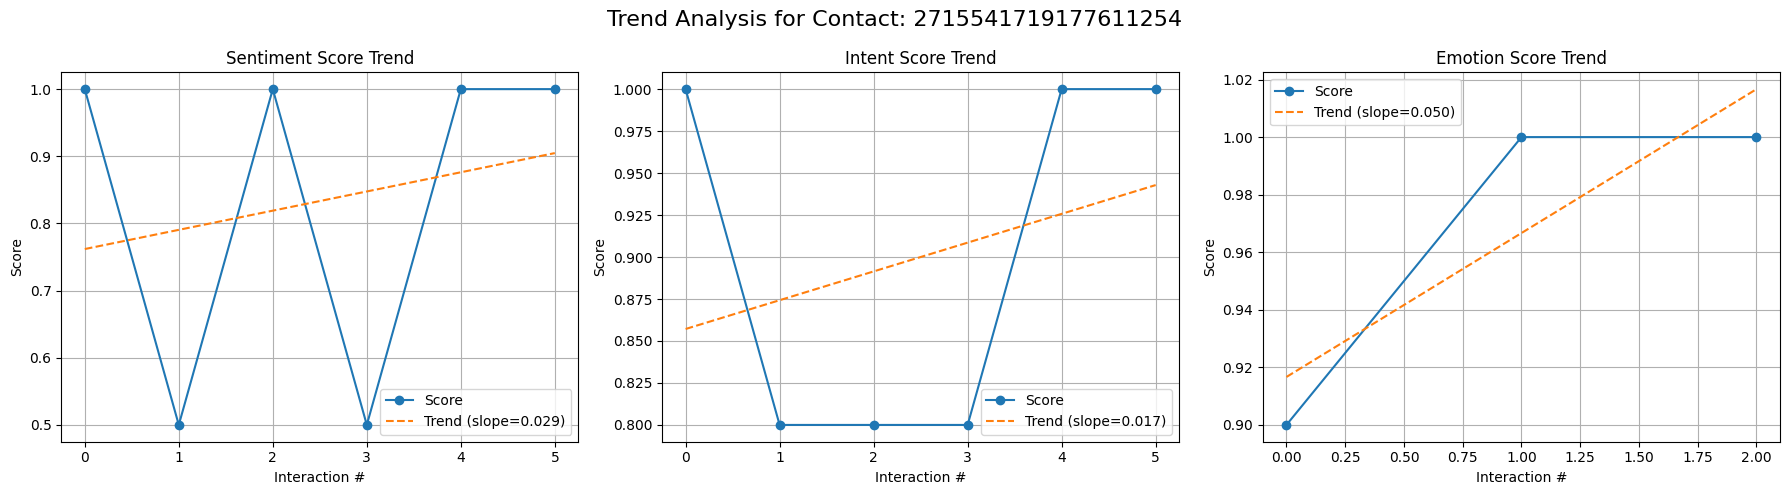

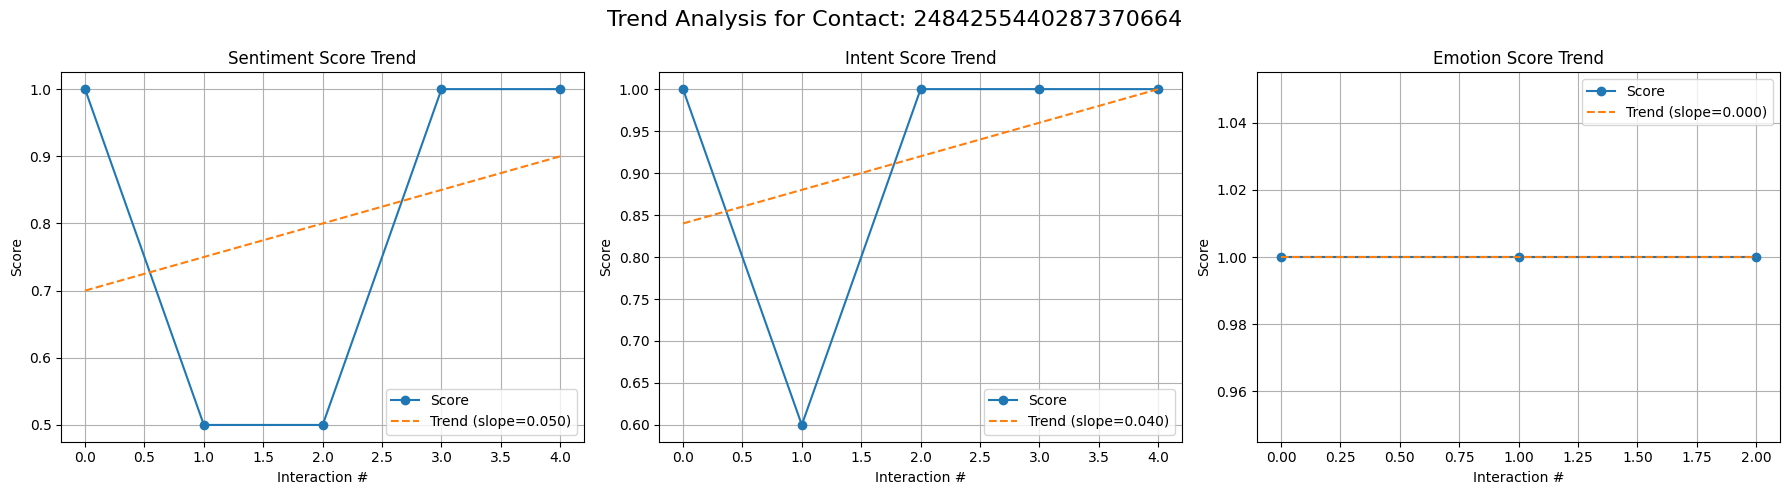

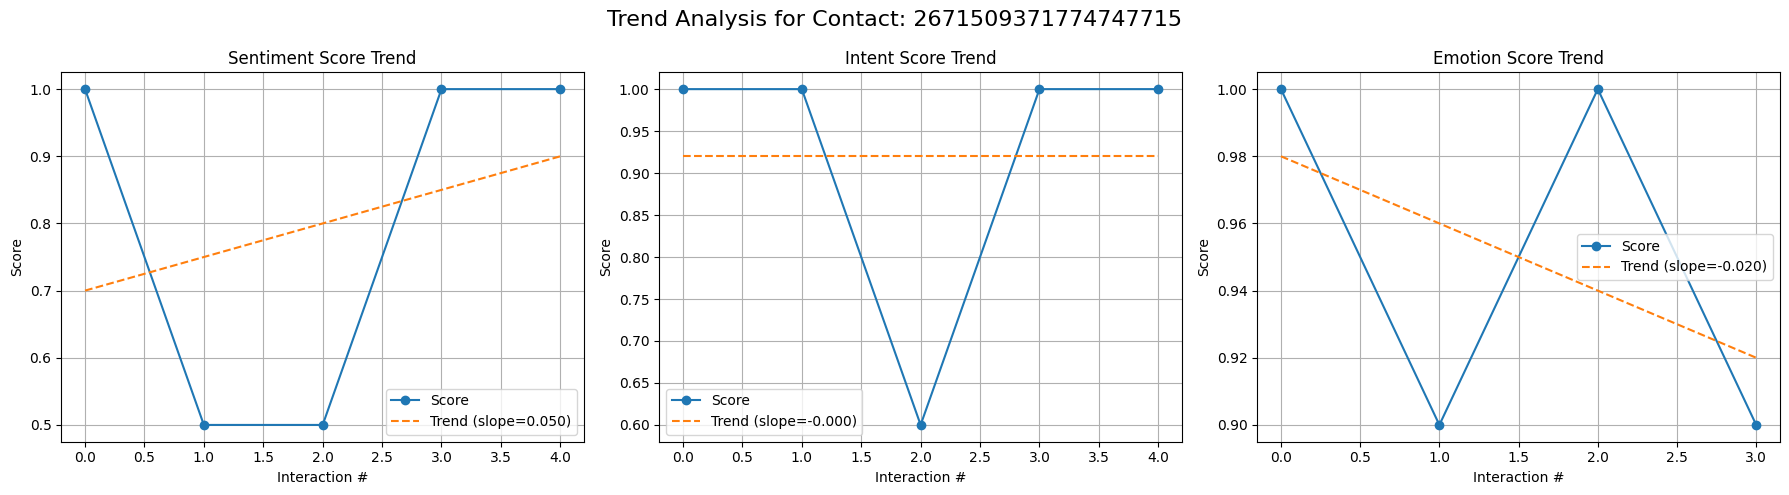


------Contacts with losing deals------



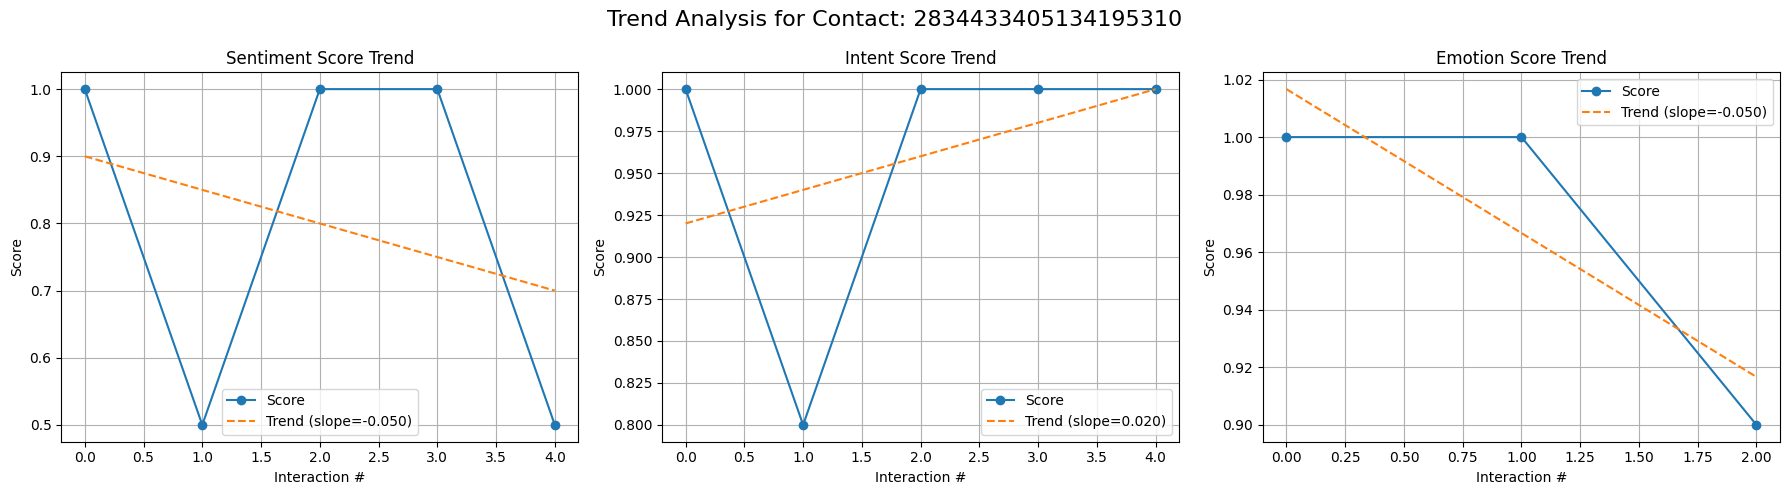

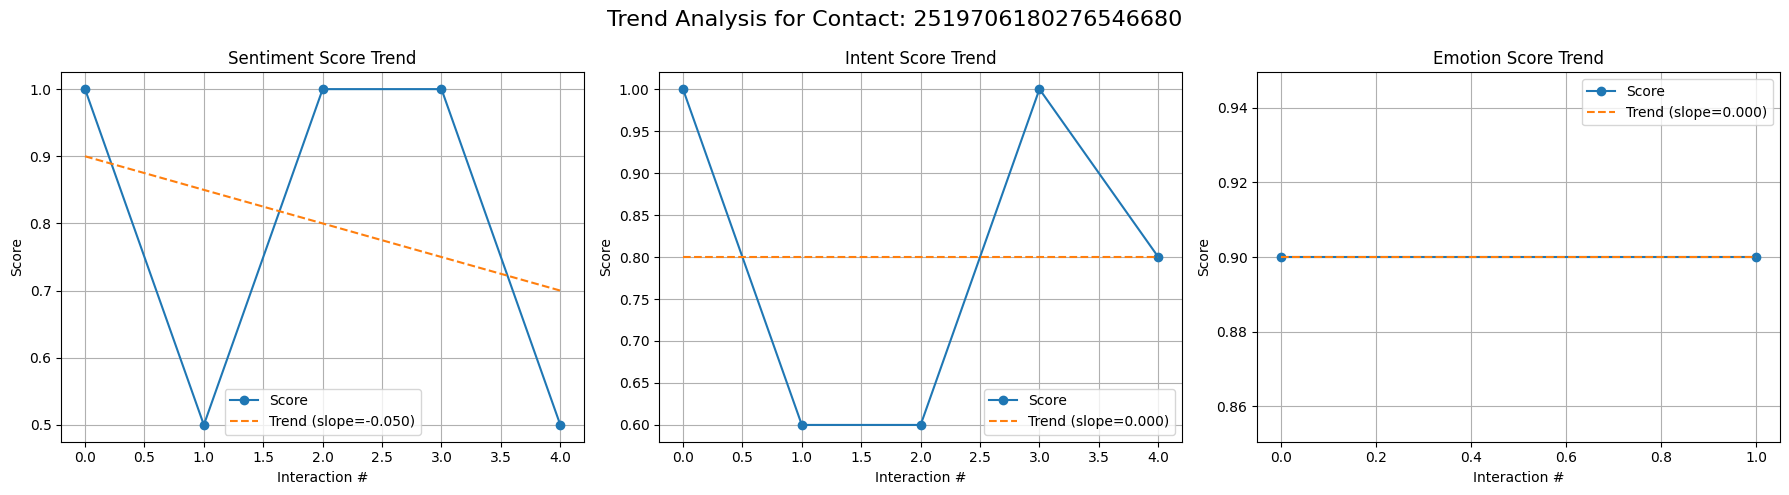

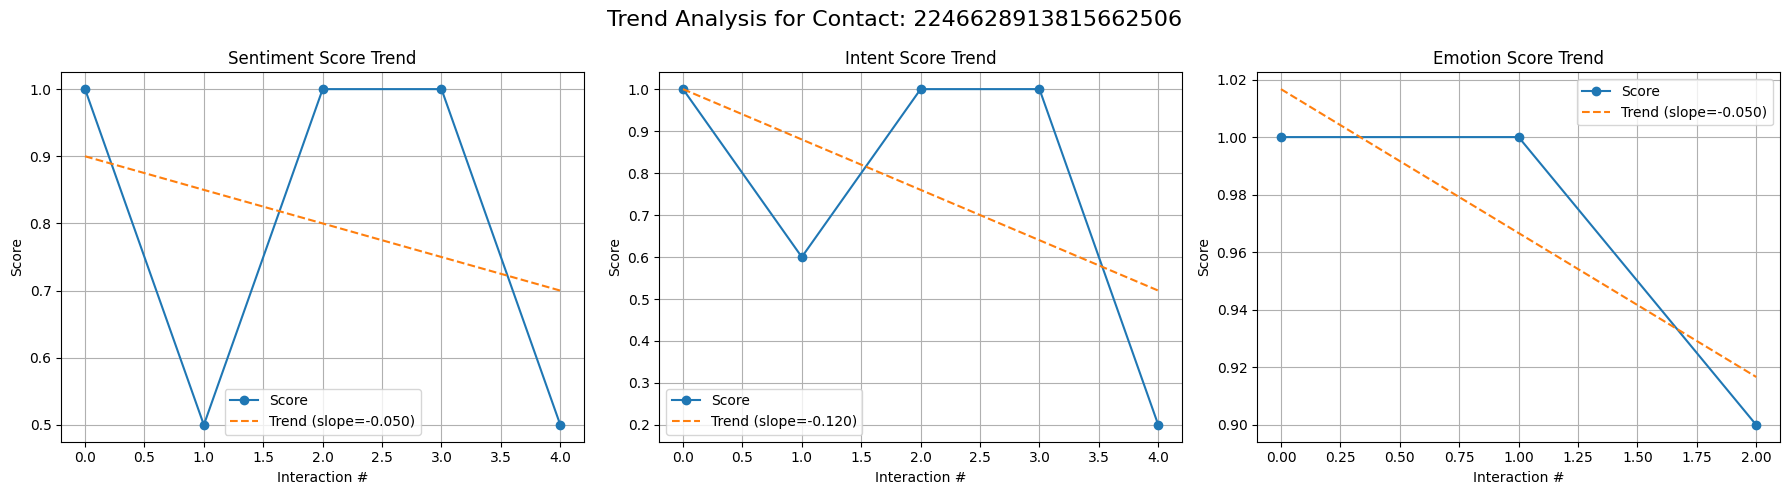

In [64]:
def plot_contact_trends(df, contact_id):
    contact_df = df[df["contact_id"] == contact_id].sort_values("timestamp")

    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    score_types = ["sentiment_score", "intent_score", "emotion_score"]
    titles = ["Sentiment Score Trend", "Intent Score Trend", "Emotion Score Trend"]

    for i, score_type in enumerate(score_types):
        scores = contact_df[score_type].dropna().tolist()
        if len(scores) < 2:
            axs[i].set_title(f"{titles[i]} (Not enough data)")
            continue

        x = np.arange(len(scores)).reshape(-1, 1)
        y = np.array(scores).reshape(-1, 1)
        model = LinearRegression().fit(x, y)
        trend_line = model.predict(x)

        axs[i].plot(x, y, marker='o', label="Score")
        axs[i].plot(x, trend_line, linestyle='--', label=f"Trend (slope={model.coef_[0][0]:.3f})")
        axs[i].set_title(titles[i])
        axs[i].set_xlabel("Interaction #")
        axs[i].set_ylabel("Score")
        axs[i].legend()
        axs[i].grid(True)

    fig.suptitle(f"Trend Analysis for Contact: {contact_id}", fontsize=16)
    plt.tight_layout()
    plt.show()


print('\n------Contacts with winning deals------\n')
for i in closed_won:
    plot_contact_trends(df, i)

print('\n------Contacts with losing deals------\n')

for i in closed_lost:
    plot_contact_trends(df, i)

## Extracting features for contact persona

In [65]:
def compute_trend(values):
    if len(values) < 2:
        return 0
    x = np.arange(len(values)).reshape(-1, 1)
    y = np.array(values).reshape(-1, 1)
    model = LinearRegression().fit(x, y)
    return model.coef_[0][0]

contact_features = []
engagement_weights = {"call": 1, "email": 0.5, "meeting": 1, "invoice": 1, "salesorder": 1, "quote": 1}

for contact_id, group in df.groupby("contact_id"):
    deals = group["deal_id"].nunique()
    amount = group.drop_duplicates("deal_id")["deal_amount"].sum()
    stages = group.drop_duplicates("deal_id")["deal_stage"].nunique()
    deal_win_rate = group[group["class_tag"] == "closed won"].shape[0] / group.shape[0] if group.shape[0] > 0 else 0
    activity_count = group.shape[0]

    # Trend-based scores across all activities in the account
    intent_score = compute_trend(group["intent_score"].dropna().tolist())
    sentiment_score = compute_trend(group["sentiment_score"].dropna().tolist())
    emotion_score = compute_trend(group["emotion_score"].dropna().tolist())

    # Sort timestamps and compute avg gap in days
    timestamps = group.sort_values("timestamp")["timestamp"]

    if len(timestamps) > 1:
        gaps = timestamps.diff().dt.days.dropna()
        activity_frequency = gaps.mean()
    else:
        days_since_last = (pd.Timestamp.now() - timestamps.iloc[0]).days
        activity_frequency = days_since_last

    recency = (pd.Timestamp.now() - group["timestamp"].max()).days
    engagement_score = group["activity_type"].map(engagement_weights).sum()

    contact_features.append({
        "contact_id": contact_id,
        "num_deals": deals,
        "sum_deal_amount": amount,
        "deal_stages": stages,
        "deal_win_rate": deal_win_rate,
        "activity_count": activity_count,
        "recency": recency,
        "activity_frequency": activity_frequency,
        "engagement_score": engagement_score,
        "intent_score": intent_score,
        "sentiment_score": sentiment_score,
        "emotion_score": emotion_score
    })

features_df = pd.DataFrame(contact_features)

## Binning Rules

In [66]:
binning_rules = {}

for column in ["num_deals", "sum_deal_amount", "deal_stages", "deal_win_rate", "activity_count", "recency", "activity_frequency", 'intent_score', 'emotion_score', 'sentiment_score', "engagement_score"]:
    values = features_df[column]
    if (column == "activity_frequency" or column == 'recency'):
        bins = {
            "q3": round(values.quantile(0.75), 2),
            "q2": round(values.quantile(0.50), 2),
            "q1": round(values.quantile(0.25), 2)
        }
    else:
        bins = {
            "q1": round(values.quantile(0.25), 2),
            "q2": round(values.quantile(0.50), 2),
            "q3": round(values.quantile(0.75), 2)
        }
    binning_rules[column] = bins

In [67]:
def bin_score(value, thresholds, reverse=False):
    if reverse:
        if value <= thresholds["q1"]:
            return 1.0
        elif value <= thresholds["q2"]:
            return 0.75
        elif value <= thresholds["q3"]:
            return 0.5
        else:
            return 0.2
    else:
        if value <= thresholds["q1"]:
            return 0.2
        elif value <= thresholds["q2"]:
            return 0.5
        elif value <= thresholds["q3"]:
            return 0.75
        else:
            return 1.0

## Computing final persona score based on weights of each feature scores

In [68]:
def compute_contact_persona_score(contact_features, weights, binning_rules):
    individual_scores = {}
    weighted_scores = []

    for key in binning_rules:
        thresholds = binning_rules[key]
        reverse = (key == "activity_frequency" or key == "recency")
        if key not in ["intent_score", "emotion_score", "sentiment_score"]:
          score = bin_score(contact_features[key], thresholds, reverse)
        else:
          score = contact_features[key]
        individual_scores[key] = score
        weighted_scores.append(score * weights.get(key, 1.0))

    total_weight = sum(weights.values())
    final_score = sum(weighted_scores) / total_weight if total_weight else 0

    return {
        "contact_id": contact_features["contact_id"],
        "final_persona_score": round(final_score, 3),
        "individual_feature_scores": individual_scores
    }

In [69]:
weights = {
    "num_deals": 1.0,
    "sum_deal_amount": 0.5,
    "deal_stages": 1.0,
    "deal_win_rate": 0.5,
    "activity_count": 1,
    "recency": 0.5,
    "activity_frequency": 1.0,
    "engagement_score": 1.0
}

## Storing the result for comparison

In [70]:
scored_personas = [compute_contact_persona_score(row, weights, binning_rules) for row in contact_features]

result_df = [json_data for json_data in scored_personas]

# Flatten it
flat_data = []
for row in result_df:
    base = {
        'contact_id': row['contact_id'],
        'final_persona_score': row['final_persona_score']
    }
    base.update(row['individual_feature_scores'])  # flatten the nested dict
    flat_data.append(base)

# Create DataFrame
result_df = pd.DataFrame(flat_data)

## Comparsion of contact features scores and change in bins

In [71]:
df_before=pd.read_csv('scored_personas_v1_new.csv')

In [72]:
def compute_trends(values):
    values = [v for v in values if v is not None and not np.isnan(v)]
    n = len(values)
    if n < 2:
        return 0.0, n
    x = np.arange(n).reshape(-1,1)
    y = np.array(values).reshape(-1,1)
    model = LinearRegression().fit(x, y)
    slope = float(model.coef_[0][0])
    return slope, n

def interpret_trend_slope(scores, feature_name="", semantic_neutral=0.5):
    clean = [s for s in scores if s is not None and not np.isnan(s)]
    n = len(clean)
    if n < 2:
        return {
            "label": "Insufficient Data",
            "norm_slope": 0.0,
            "slope_per_step": 0.0,
            "n": n,
            "avg_score": None,
            "thresholds": None,
            "behaviour": f"Not enough {feature_name} data to determine a trend."
        }

    slope, n = compute_trends(clean)
    norm_slope = slope * (n - 1)  # total change over period
    start = clean[0]
    end = clean[-1]
    avg = float(np.mean(clean))

    # Determine movement type
    if abs(norm_slope) < 1e-6:
        label = "No Change"
        if avg > semantic_neutral:
            behaviour = f"The contact {feature_name} remained consistently positive."
        elif avg < semantic_neutral:
            behaviour = f"The contact {feature_name} remained consistently negative."
        else:
            behaviour = f"The contact {feature_name} stayed neutral throughout."
    else:
        if start < semantic_neutral and end > semantic_neutral:
            label = "Negative to Positive"
            behaviour = f"The contact {feature_name} improved from negative to positive over time."
        elif start > semantic_neutral and end < semantic_neutral:
            label = "Positive to Negative"
            behaviour = f"The contact {feature_name} declined from positive to negative over time."
        elif start > semantic_neutral and end > semantic_neutral:
            if norm_slope > 0:
                label = "Strengthening Positive"
                behaviour = f"The contact {feature_name} became more positive."
            else:
                label = "Weakening Positive"
                behaviour = f"The contact {feature_name} became less positive."
        elif start < semantic_neutral and end < semantic_neutral:
            if norm_slope > 0:
                label = "Strengthening Negative"
                behaviour = f"The contact {feature_name} became more negative."
            else:
                label = "Weakening Negative"
                behaviour = f"The contact {feature_name} became less negative."
        else:
            label = "Around Neutral"
            behaviour = f"The contact {feature_name} stayed near neutral values."

    return {
        "label": label,
        "norm_slope": round(norm_slope, 4),
        "slope_per_step": round(slope, 5),
        "n": n,
        "avg_score": round(avg, 3),
        "thresholds": None,
        "behaviour": behaviour
    }

def get_original_bin_label(score, thresholds):
      if score == 0.2:
          return f"Poorly Engaged (<={thresholds['min']:.2f})"
      elif score == 0.5:
          return f"Moderately Engaged ({thresholds['min']:.2f} - {thresholds['avg']:.2f})"
      else:
          return f"Highly Engaged (>{thresholds['avg']:.2f})"

def get_updated_bin_label(score, thresholds):
      if score == 0.2:
          return f"Very Low Engagement (<={thresholds['q1']:.2f})"
      elif score == 0.5:
          return f"Moderately Low Engagement ({thresholds['q1']:.2f} - {thresholds['q2']:.2f})"
      elif score == 0.75:
          return f"Moderately High Engagement ({thresholds['q2']:.2f} - {thresholds['q3']:.2f})"
      else:
          return f"Very High Engagement (>{thresholds['q3']:.2f})"

original_binning_rules = {
 'num_deals': {'min': 1, 'avg': np.float64(1.0), 'max': 1},
 'sum_deal_amount': {'min': 0.0, 'avg': np.float64(0.0), 'max': 0.0},
 'deal_stages': {'min': 1, 'avg': np.float64(1.0), 'max': 1},
 'activity_count': {'min': 5, 'avg': np.float64(5.4), 'max': 7},
 'activity_frequency': {'max': 1.0, 'avg': np.float64(0.69), 'min': 0.0},
 'engagement_score': {'min': 3.0, 'avg': np.float64(3.2), 'max': 4.0}
}

In [73]:
def compare_contact_metrics(contact_id_to_compare, df_before, result_df):

    # 🔹 Get subset of data for the contact
    df_b = df_before[df_before['contact_id'] == contact_id_to_compare]
    df_r = result_df[result_df['contact_id'] == contact_id_to_compare]

    # Check if empty before accessing iloc
    if df_b.empty or df_r.empty:
        return pd.DataFrame([{
            "Feature": "N/A",
            "Original Threshold": None,
            "Original Score": None,
            "Original Bin": None,
            "Updated Threshold": None,
            "Updated Score": None,
            "Updated Bin": None,
            "Trend": None,
            "Error": f"No matching data found for contact_id {contact_id_to_compare}"
        }])

    # Safe indexing
    contact_before = df_b.iloc[0]
    contact_after = df_r.iloc[0]

    features_to_bin = [
        'num_deals', 'sum_deal_amount', 'deal_stages', 'deal_win_rate', 'recency',
        'activity_count', 'activity_frequency', 'engagement_score',
        'intent_score', 'emotion_score', 'sentiment_score'
    ]

    rows = []

    for feat in features_to_bin:
        row = {
            "Feature": feat,
            "Original Threshold": None,
            "Original Score": None,
            "Original Bin": None,
            "Updated Threshold": None,
            "Updated Score": None,
            "Updated Bin": None,
            "Trend": None
        }

        # Original binning
        if feat in contact_before and feat in original_binning_rules:
            score_before = contact_before[feat]
            thresholds_original = original_binning_rules[feat]
            bin_label_original = get_original_bin_label(score_before, thresholds_original)
            row["Original Threshold"] = str(thresholds_original)
            row["Original Score"] = round(float(score_before), 2)
            row["Original Bin"] = bin_label_original

        # Updated binning or trend
        if feat in ["intent_score", "emotion_score", "sentiment_score"]:
            group = df[df["contact_id"] == contact_id_to_compare]
            scores = group[feat].dropna().tolist()
            trend_info = interpret_trend_slope(scores, feature_name=feat.replace("_score", ""))
            row["Updated Score"] = trend_info["norm_slope"]
            row["Updated Bin"] = trend_info["label"]
            row["Trend"] = trend_info["behaviour"]
        elif feat in contact_after and feat in binning_rules:
            score_after = contact_after[feat]
            thresholds_updated = binning_rules[feat]
            bin_label_updated = get_updated_bin_label(score_after, thresholds_updated)
            row["Updated Threshold"] = str(thresholds_updated)
            row["Updated Score"] = round(float(score_after), 2)
            row["Updated Bin"] = bin_label_updated

        rows.append(row)

    return pd.DataFrame(rows)

df_metrics = compare_contact_metrics(2037505279937603756, df_before, result_df)
display(df_metrics)


,Feature,Original Threshold,Original Score,Original Bin,Updated Threshold,Updated Score,Updated Bin,Trend
0,num_deals,"{'min': 1, 'avg': np.float64(1.0), 'max': 1}",0.2,Poorly Engaged (<=1.00),"{'q1': np.float64(1.0), 'q2': np.float64(1.0),...",0.2000,Very Low Engagement (<=1.00),None
1,sum_deal_amount,"{'min': 0.0, 'avg': np.float64(0.0), 'max': 0.0}",0.2,Poorly Engaged (<=0.00),"{'q1': np.float64(0.0), 'q2': np.float64(0.0),...",0.2000,Very Low Engagement (<=0.00),None
2,deal_stages,"{'min': 1, 'avg': np.float64(1.0), 'max': 1}",0.2,Poorly Engaged (<=1.00),"{'q1': np.float64(1.0), 'q2': np.float64(1.0),...",0.2000,Very Low Engagement (<=1.00),None
3,deal_win_rate,None,NaN,None,"{'q1': np.float64(0.0), 'q2': np.float64(1.0),...",0.5000,Moderately Low Engagement (0.00 - 1.00),None
4,recency,None,NaN,None,"{'q3': np.float64(44.25), 'q2': np.float64(38....",0.7500,Moderately High Engagement (38.00 - 44.25),None
5,activity_count,"{'min': 5, 'avg': np.float64(5.4), 'max': 7}",1.0,Highly Engaged (>5.40),"{'q1': np.float64(5.0), 'q2': np.float64(5.0),...",1.0000,Very High Engagement (>5.00),None
6,activity_frequency,"{'max': 1.0, 'avg': np.float64(0.69), 'min': 0.0}",0.2,Poorly Engaged (<=0.00),"{'q3': np.float64(0.75), 'q2': np.float64(0.75...",0.2000,Very Low Engagement (<=0.50),None
7,engagement_score,"{'min': 3.0, 'avg': np.float64(3.2), 'max': 4.0}",1.0,Highly Engaged (>3.20),"{'q1': np.float64(3.0), 'q2': np.float64(3.0),...",1.0000,Very High Engagement (>3.00),None
8,intent_score,None,NaN,None,None,0.3143,Strengthening Positive,The contact intent became more positive.
9,emotion_score,None,NaN,None,None,0.0000,No Change,The contact emotion remained consistently posi...


## JSON output for 5 contacts

In [78]:
def add_labels_to_personas(scored_personas, binning_rules, get_updated_bin_label, interpret_trend_slope):
    """
    Adds bin labels to scored_personas JSON using updated binning rules.
    """
    updated_personas = []

    for persona in scored_personas:
        new_persona = persona.copy()
        labels = {}
        contact_id = persona["contact_id"]

        for feat, score in persona["individual_feature_scores"].items():
            if feat in binning_rules:
                if feat in ["intent_score", "emotion_score", "sentiment_score"]:
                  group = df[df["contact_id"] == contact_id]
                  scores = group[feat].dropna().tolist()
                  bin_label = interpret_trend_slope(scores, feat)
                  labels[feat] = bin_label['label']
                else:
                  thresholds = binning_rules[feat]
                  bin_label = get_updated_bin_label(score, thresholds)
                  labels[feat] = bin_label


        new_persona["labels"] = labels
        updated_personas.append(new_persona)

    return updated_personas

import pprint

contacts_map = {
    "winning deals": closed_won,
    "losing deals": closed_lost
}

for label, contact_list in contacts_map.items():
    print(f"\n------Contacts with {label}------\n")

    filtered_personas = [
        persona for persona in scored_personas
        if persona.get("contact_id") in contact_list
    ]

    scored_personas_with_labels = add_labels_to_personas(
        filtered_personas,
        binning_rules,
        get_updated_bin_label,
        interpret_trend_slope
    )

    pprint.pprint(scored_personas_with_labels)


------Contacts with winning deals------

[{'contact_id': 2484255440287370664,
  'final_persona_score': np.float64(0.364),
  'individual_feature_scores': {'activity_count': 0.2,
                                'activity_frequency': 0.75,
                                'deal_stages': 0.2,
                                'deal_win_rate': 0.5,
                                'emotion_score': np.float64(0.0),
                                'engagement_score': 0.2,
                                'intent_score': np.float64(0.04),
                                'num_deals': 0.2,
                                'recency': 0.75,
                                'sentiment_score': np.float64(0.04999999999999998),
                                'sum_deal_amount': 0.2},
  'labels': {'activity_count': 'Very Low Engagement (<=5.00)',
             'activity_frequency': 'Moderately High Engagement (0.75 - 0.75)',
             'deal_stages': 'Very Low Engagement (<=1.00)',
             'deal_win_ra

## Comparision of change in bins of all features between current version and updated version as charts

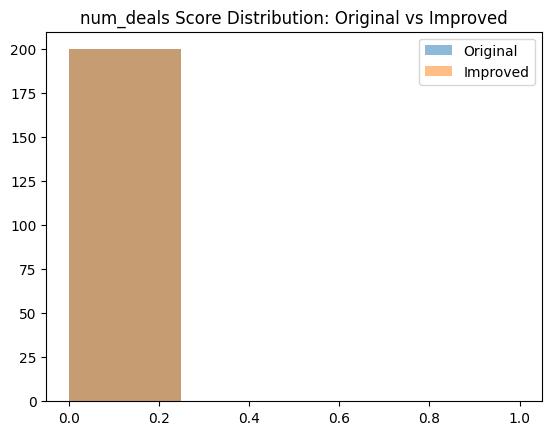

       num_deals_before  num_deals_after
count      2.000000e+02     2.000000e+02
mean       2.000000e-01     2.000000e-01
std        1.391261e-16     1.391261e-16
min        2.000000e-01     2.000000e-01
25%        2.000000e-01     2.000000e-01
50%        2.000000e-01     2.000000e-01
75%        2.000000e-01     2.000000e-01
max        2.000000e-01     2.000000e-01


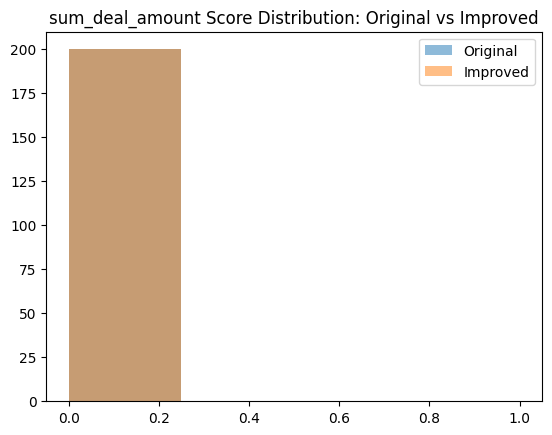

       sum_deal_amount_before  sum_deal_amount_after
count            2.000000e+02           2.000000e+02
mean             2.000000e-01           2.000000e-01
std              1.391261e-16           1.391261e-16
min              2.000000e-01           2.000000e-01
25%              2.000000e-01           2.000000e-01
50%              2.000000e-01           2.000000e-01
75%              2.000000e-01           2.000000e-01
max              2.000000e-01           2.000000e-01


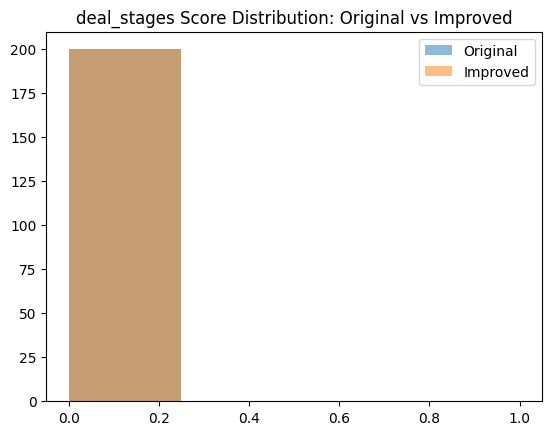

       deal_stages_before  deal_stages_after
count        2.000000e+02       2.000000e+02
mean         2.000000e-01       2.000000e-01
std          1.391261e-16       1.391261e-16
min          2.000000e-01       2.000000e-01
25%          2.000000e-01       2.000000e-01
50%          2.000000e-01       2.000000e-01
75%          2.000000e-01       2.000000e-01
max          2.000000e-01       2.000000e-01


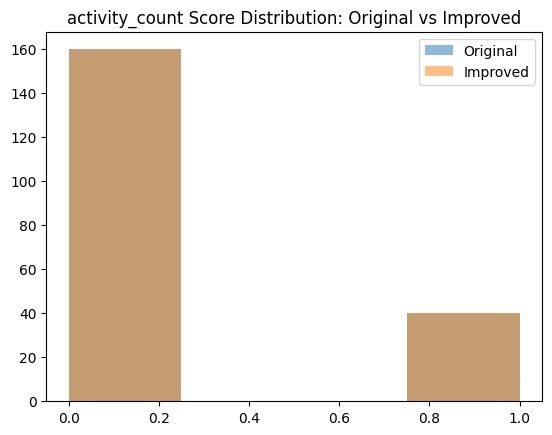

       activity_count_before  activity_count_after
count             200.000000            200.000000
mean                0.360000              0.360000
std                 0.320803              0.320803
min                 0.200000              0.200000
25%                 0.200000              0.200000
50%                 0.200000              0.200000
75%                 0.200000              0.200000
max                 1.000000              1.000000


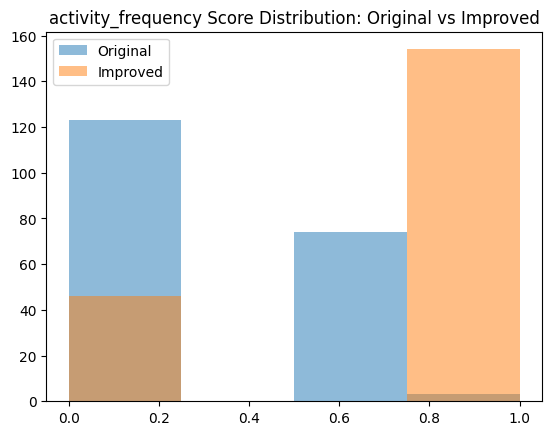

       activity_frequency_before  activity_frequency_after
count                 200.000000                 200.00000
mean                    0.323000                   0.70100
std                     0.167065                   0.29493
min                     0.200000                   0.20000
25%                     0.200000                   0.75000
50%                     0.200000                   0.75000
75%                     0.500000                   1.00000
max                     1.000000                   1.00000


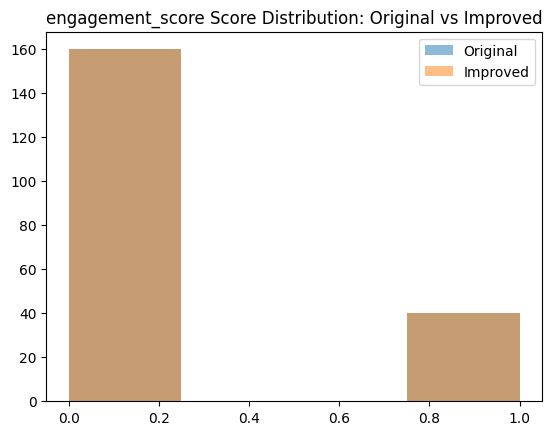

       engagement_score_before  engagement_score_after
count               200.000000              200.000000
mean                  0.360000                0.360000
std                   0.320803                0.320803
min                   0.200000                0.200000
25%                   0.200000                0.200000
50%                   0.200000                0.200000
75%                   0.200000                0.200000
max                   1.000000                1.000000


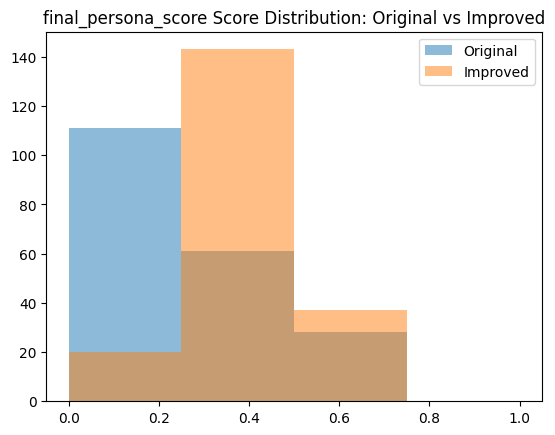

       final_persona_score_before  final_persona_score_after
count                  200.000000                 200.000000
mean                     0.280590                   0.375550
std                      0.128876                   0.121587
min                      0.200000                   0.132000
25%                      0.200000                   0.303250
50%                      0.200000                   0.349000
75%                      0.255000                   0.410000
max                      0.636000                   0.672000


In [48]:
compare_df = df_before.merge(
    result_df,
    on="contact_id",
    suffixes=("_before", "_after")
)

features = ['num_deals', 'sum_deal_amount', 'deal_stages',
            'activity_count', 'activity_frequency', 'engagement_score', 'final_persona_score']

for metric in features:
  min_val = min(df_before[f'{metric}'].min(), result_df[f'{metric}'].min())
  max_val = max(df_before[f'{metric}'].max(), result_df[f'{metric}'].max())
  bins = np.linspace(0, 1, 5)

  plt.hist(df_before[f'{metric}'], bins=bins, alpha=0.5, label='Original')
  plt.hist(result_df[f'{metric}'], bins=bins, alpha=0.5, label='Improved')
  plt.legend()
  plt.title(f"{metric} Score Distribution: Original vs Improved")
  plt.show()

  print(compare_df[[f'{metric}_before', f'{metric}_after']].describe())


## Prediction

In [49]:
def score_new_contact(contact_id, deal_records, activity_records, weights, binning_rules, engagement_weights):
    df_deals = pd.DataFrame(deal_records)
    df_activities = pd.DataFrame(activity_records)

    merged = pd.merge(df_activities, df_deals, on="deal_id")

    deals = group["deal_id"].nunique()
    amount = group.drop_duplicates("deal_id")["deal_amount"].sum()
    stages = group.drop_duplicates("deal_id")["deal_stage"].nunique()
    deal_win_rate = group[group["class_tag"] == "closed won"].shape[0] / group.shape[0] if group.shape[0] > 0 else 0
    activity_count = group.shape[0]

    # Trend-based scores across all activities in the account
    intent_score = compute_trend(group["intent_score"].dropna().tolist())
    sentiment_score = compute_trend(group["sentiment_score"].dropna().tolist())
    emotion_score = compute_trend(group["emotion_score"].dropna().tolist())

    # Sort timestamps and compute avg gap in days
    timestamps = group.sort_values("timestamp")["timestamp"]

    if len(timestamps) > 1:
        gaps = timestamps.diff().dt.days.dropna()
        activity_frequency = gaps.mean()
    else:
        days_since_last = (pd.Timestamp.now() - timestamps.iloc[0]).days
        activity_frequency = days_since_last

    recency = (pd.Timestamp.now() - group["timestamp"].max()).days
    engagement_score = group["activity_type"].map(engagement_weights).sum()

    contact_features = {
        "contact_id": contact_id,
        "num_deals": deals,
        "sum_deal_amount": amount,
        "deal_stages": stages,
        "deal_win_rate": deal_win_rate,
        "activity_count": activity_count,
        "recency": recency,
        "activity_frequency": activity_frequency,
        "engagement_score": engagement_score,
        "intent_score": intent_score,
        "sentiment_score": sentiment_score,
        "emotion_score": emotion_score
    }

    return compute_contact_persona_score(contact_features, weights, binning_rules)

In [50]:
example_deal_records = [
    {"deal_id": "DX1", "contact_id": "C1", "deal_amount": 9000, "deal_stage": "Proposal"},
    {"deal_id": "DX2", "contact_id": "C1", "deal_amount": 14000, "deal_stage": "Won"},
    {"deal_id": "DX3", "contact_id": "C2", "deal_amount": 3000, "deal_stage": "Negotiation"}
]

example_activity_records = [
    {
        "deal_id": "DX1",
        "activity_type": "call",
        "timestamp": datetime.now() - timedelta(days=5),
        "intent": "Request",
        "emotion": "Neutral",
        "sentiment": "Neutral"
    },
    {
        "deal_id": "DX1",
        "activity_type": "email",
        "timestamp": datetime.now() - timedelta(days=3),
        "intent": "Request",
        "emotion": "Happy",
        "sentiment": "Positive"
    },
    {
        "deal_id": "DX2",
        "activity_type": "meeting",
        "timestamp": datetime.now() - timedelta(days=1),
        "intent": "Purchase",
        "emotion": "Enthusiasm",
        "sentiment": "Positive"
    },
    {
        "deal_id": "DX3",
        "activity_type": "email",
        "timestamp": datetime.now() - timedelta(days=2),
        "intent": "Gratitude",
        "emotion": "Neutral",
        "sentiment": "Neutral"
    }
]

In [51]:
new_contact_score = score_new_contact("CNew", example_deal_records, example_activity_records, weights, binning_rules, engagement_weights)
print("\nScored new contact:")
print(json.dumps(new_contact_score, indent=2))



Scored new contact:
{
  "contact_id": "CNew",
  "final_persona_score": 0.352,
  "individual_feature_scores": {
    "num_deals": 0.2,
    "sum_deal_amount": 0.2,
    "deal_stages": 0.2,
    "deal_win_rate": 0.5,
    "activity_count": 0.2,
    "recency": 0.5,
    "activity_frequency": 0.75,
    "intent_score": 0.04,
    "emotion_score": 0.049999999999999954,
    "sentiment_score": 0.04999999999999998,
    "engagement_score": 0.2
  }
}
